Prerequisites

Before running this notebook, the following tasks must be completed:

1. Download + preprocess the data by running `data/luo_2022_atlas.py`
2. Run `experiment_scripts/run_atlas_experiment.py` for each baseline model
3. Run `experiment_scripts/calculate_atlas.metrics.py`

In [1]:
import mudata
import scanpy as sc
import pickle
from collections import defaultdict
from tqdm import tqdm
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import Rectangle, Circle
from matplotlib.gridspec import GridSpec
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.collections as coll
sc._settings.settings._vector_friendly = True

mm = 1/25.4

fontsize = 7
border_width = 0.5
matplotlib.rcParams.update({'font.size': fontsize})
matplotlib.rcParams.update({'axes.titlesize': fontsize})
matplotlib.rcParams['font.family'] = 'sans-serif'
largest_dot = 200
smallest_dot = 10
size_exponent = 1.5


mdata = mudata.read_h5mu(
    "/projects/leelab3/methylVI/Luo2022_atlas/data/gene_2500_features.h5mu"
)

def reformat_sample_name(x):
    if x == "UMB4540_hs_25yr":
        return "UMB4540 (snmC-seq)"
    elif x == "NDARKD326LNK_hs_25yr":
        return "NDARKD326LNK (snmC-seq2)"
    elif x == "NDARKJ183CYT_hs_58yr":
        return "NDARKJ183CYT (snmC-seq)"
    elif x == "mCTseq_hs_21yr":
        return "UMB5577 (snmC2T-seq)"
    elif x == "mCTseq_hs_29yr":
        return "UMB5580 (snmC2T-seq)"
    elif x == "snm3Cseq_hs_21yr":
        return "UMB5577 (sn-m3C-seq)"
    elif x == "snm3Cseq_hs_29yr":
        return "UMB5580 (sn-m3C-seq)"

mdata.obs['sample_clean'] = [reformat_sample_name(x) for x in mdata.obs['mCG:sample']]

In [2]:
query_dataset = "NDARKD326LNK_hs_25yr"

In [3]:
per_model_batch_correction_metrics_dicts = {}
per_model_bio_conservation_metrics_dicts = {}

models = ['methylANVI_arches', 'methylANVI_denovo', 'methylVI_denovo', 'mnn', 'harmony', 'scanorama', 'seurat', 'unintegrated']

for model in models:
    per_model_batch_correction_metrics_dicts[model] = pickle.load(
        open(f"/projects/leelab3/methylVI/Luo2022_atlas_integration/{query_dataset}/{model}_batch_correction_metrics.pkl", "rb")
    )

    per_model_bio_conservation_metrics_dicts[model] = pickle.load(
        open(f"/projects/leelab3/methylVI/Luo2022_atlas_integration/{query_dataset}/{model}_bio_conservation_metrics.pkl", "rb")
    )

batch_correction_metrics_dict = defaultdict(defaultdict(int).copy)
batch_correction_metric_names = per_model_batch_correction_metrics_dicts[models[0]].keys()

for metric in batch_correction_metric_names:
    for model in models:
        batch_correction_metrics_dict[metric][model] = per_model_batch_correction_metrics_dicts[model][metric]

bio_conservation_metrics_dict = defaultdict(defaultdict(int).copy)
bio_conservation_metric_names = per_model_bio_conservation_metrics_dicts[models[0]].keys()
for metric in bio_conservation_metric_names:
    for model in models:
        bio_conservation_metrics_dict[metric][model] = per_model_bio_conservation_metrics_dicts[model][metric]

In [4]:
bio_conservation_score_matrix = pd.DataFrame(bio_conservation_metrics_dict)


In [5]:
bio_conservation_score_matrix = pd.DataFrame(
    data=MinMaxScaler().fit_transform(bio_conservation_score_matrix),
    index=bio_conservation_score_matrix.index,
    columns=bio_conservation_score_matrix.columns
)
bio_conservation_total_name = "Bio-Conservation\nScore"
bio_conservation_score_matrix[bio_conservation_total_name] = bio_conservation_score_matrix.mean(axis=1)
bio_conservation_score_matrix = bio_conservation_score_matrix[[bio_conservation_total_name] + [col for col in bio_conservation_score_matrix.columns if col != bio_conservation_total_name]]

batch_correction_score_matrix = pd.DataFrame(batch_correction_metrics_dict)

In [6]:
batch_correction_score_matrix

,kBET,Graph iLISI,Batch ASW,Graph connectivity,PCR batch
methylANVI_arches,0.456105,0.333149,0.853769,0.997015,0.529656
methylANVI_denovo,0.510215,0.362332,0.876199,0.997651,0.575180
methylVI_denovo,0.416018,0.336984,0.884878,0.996749,0.529544
mnn,0.537913,0.378647,0.936392,0.997800,0.380028
harmony,0.644064,0.463653,0.909935,0.997688,0.390125
scanorama,0.463233,0.342310,0.794190,0.990569,0.225416
seurat,0.094819,0.182632,0.928498,0.998414,0.009712
unintegrated,0.152798,0.215869,0.919767,0.998304,0.098052


In [7]:
batch_correction_score_matrix = pd.DataFrame(
    data=MinMaxScaler().fit_transform(batch_correction_score_matrix),
    index=batch_correction_score_matrix.index,
    columns=batch_correction_score_matrix.columns
)

batch_correction_total_name = "Batch\nCorrection\nScore"
batch_correction_score_matrix[batch_correction_total_name] = batch_correction_score_matrix.mean(axis=1)
batch_correction_score_matrix = batch_correction_score_matrix[[batch_correction_total_name] + [col for col in batch_correction_score_matrix.columns if col != batch_correction_total_name]]
total_score_matrix = pd.concat([batch_correction_score_matrix, bio_conservation_score_matrix], axis=1)
total_quality_name = "Overall\nScore"
total_score_matrix.insert(
    0,
    total_quality_name,
    (0.4*batch_correction_score_matrix[batch_correction_total_name] + 0.6*bio_conservation_score_matrix[bio_conservation_total_name]).values
)

In [8]:
total_score_matrix.rename(
    index={
        "mnn": "fastMNN",
        "unintegrated": "Unintegrated",
        "scanorama": "Scanorama",
        "harmony": "Harmony",
        "methylANVI_denovo": "methylANVI\n($\it{de\ novo}$)",
        "methylANVI_arches": "methylANVI\n(scArches)",
        "methylVI_denovo": "methylVI",
        "seurat": "Seurat",
    },
    inplace=True
)

In [9]:
total_score_matrix.sort_values(by='Overall\nScore', ascending=False, inplace=True)

In [10]:
total_score_matrix

,Overall\nScore,Batch\nCorrection\nScore,kBET,Graph iLISI,Batch ASW,Graph connectivity,PCR batch,Bio-Conservation\nScore,Cell type ARI,Cell type NMI,Cell type ASW,Isolated label F1,Isolated label ASW,Graph cLISI
methylANVI\n($\it{de\ novo}$),0.841684,0.775037,0.756305,0.639454,0.576704,0.902720,1.000000,0.886115,1.000000,1.000000,0.531895,0.944003,1.000000,0.840791
methylVI,0.708074,0.695757,0.584801,0.549254,0.637742,0.787692,0.919296,0.716285,0.920479,0.762227,0.336518,0.863615,0.731829,0.683041
methylANVI\n(scArches),0.707058,0.670697,0.657787,0.535606,0.418971,0.821625,0.919494,0.731298,0.863619,0.763040,0.557885,0.817361,0.539493,0.846392
fastMNN,0.673374,0.816156,0.806734,0.697509,1.000000,0.921652,0.654884,0.578187,0.710320,0.682751,0.194308,0.978643,0.192967,0.710130
Unintegrated,0.609591,0.449813,0.105561,0.118272,0.883087,0.985920,0.156225,0.716109,0.793809,0.694086,0.457816,1.000000,0.350946,1.000000
Harmony,0.445874,0.878831,1.000000,1.000000,0.813947,0.907470,0.672740,0.157235,0.354978,0.204442,0.000000,0.383991,0.000000,0.000000
Scanorama,0.438886,0.324087,0.670764,0.568208,0.000000,0.000000,0.381461,0.515418,0.000000,0.098986,1.000000,0.000000,0.993524,1.000000
Seurat,0.312970,0.388897,0.000000,0.000000,0.944484,1.000000,0.000000,0.262352,0.040340,0.000000,0.058224,0.978295,0.024966,0.472289


In [11]:
dot_color_df = total_score_matrix.assign(**total_score_matrix.iloc[:, 0:].rank(axis = 0).astype(int))

In [12]:
dot_color_df = dot_color_df / dot_color_df.shape[0]

In [13]:
batch_correction_metric_column_idxs = [2, 3, 4, 5, 6]
bio_conservation_metric_column_idxs = [8, 9, 10, 11, 12, 13]

/tmp/ipykernel_1957686/4246930420.py:247: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.savefig("reference_mapping_quantitative.pdf", dpi=300, transparent=True)
/homes/gws/ewein/micromamba/envs/methyl-vi-env/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  func(*args, **kwargs)
/homes/gws/ewein/micromamba/envs/methyl-vi-env/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


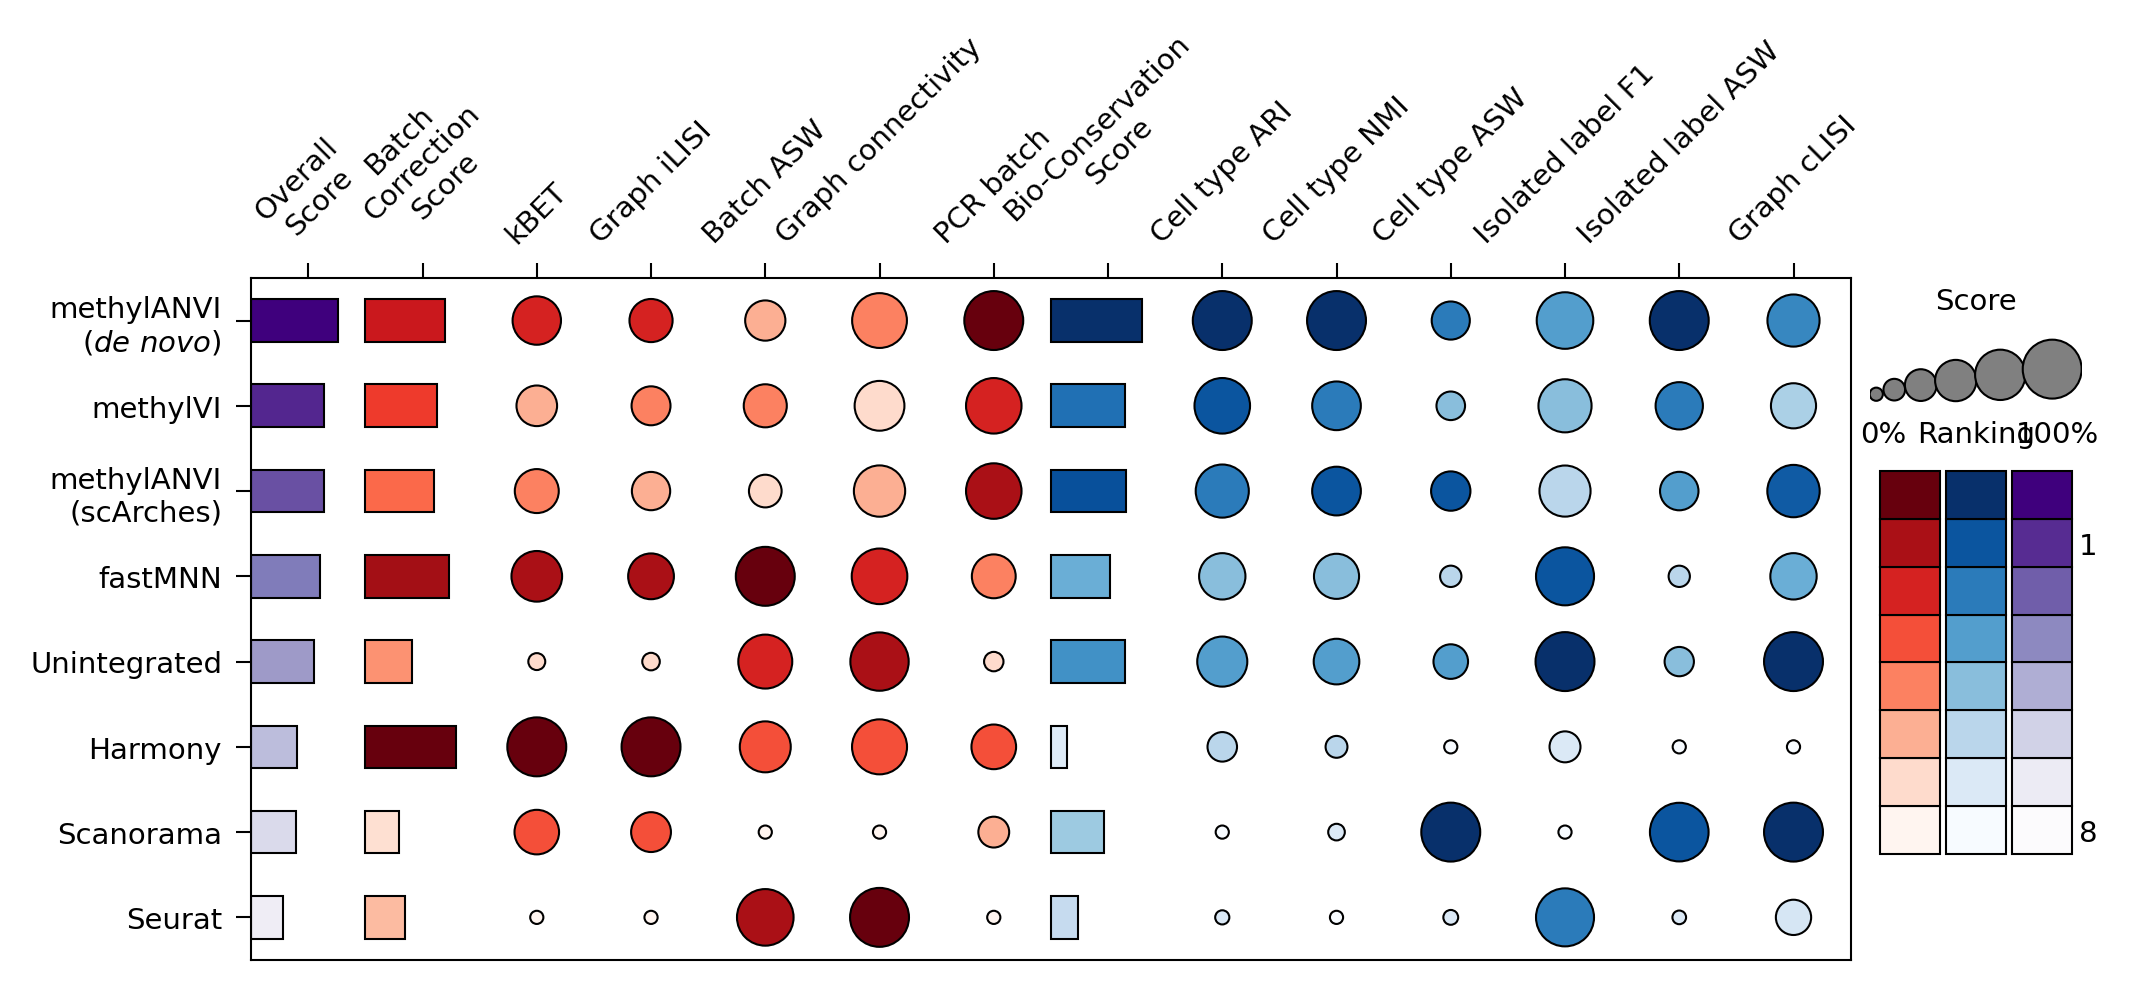

In [14]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import Rectangle, Circle
from matplotlib.gridspec import GridSpec
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.collections as coll

mm = 1/25.4

fontsize = 7
border_width = 0.5
matplotlib.rcParams.update({'font.size': fontsize})
matplotlib.rcParams.update({'axes.titlesize': fontsize})
matplotlib.rcParams['font.family'] = 'sans-serif'
largest_dot = 200
smallest_dot = 10
size_exponent = 1.5


n_metrics = dot_color_df.shape[1]
n_models = dot_color_df.shape[0]

legend_buffer = 2
fig = plt.figure(constrained_layout=True, figsize=(n_metrics + legend_buffer, n_models+0.5), dpi=300)
fig.set_size_inches(200 * mm, 75 * mm)

gs = GridSpec(n_models, n_metrics+legend_buffer, figure=fig)

dot_ax = fig.add_subplot(gs[:n_models, :n_metrics])
size_legend_ax = fig.add_subplot(gs[0:2, n_metrics:])
rank_legend_ax = fig.add_subplot(gs[2:7, n_metrics:])

salient_cmap = cm.Reds
for idx in batch_correction_metric_column_idxs:
    
    column = total_score_matrix.iloc[:, idx]
    x = [idx + 0.5 for _ in range(column.shape[0])] 
    y = np.arange(column.shape[0]) + 0.5
    
    size = total_score_matrix.iloc[:, idx]
    size = size**size_exponent
    size = size * (largest_dot - smallest_dot) + smallest_dot
    
    color = dot_color_df.iloc[:, idx]
    
    dot_ax.scatter(
        x,
        y,
        s=size,
        linewidth=border_width,
        c=color,
        cmap=salient_cmap,
        edgecolor='black'
    )
    
shared_cmap = cm.Blues
for idx in bio_conservation_metric_column_idxs:
    column = total_score_matrix.iloc[:, idx]
    x = [idx + 0.5 for _ in range(column.shape[0])] 
    y = np.arange(column.shape[0]) + 0.5
    
    size = total_score_matrix.iloc[:, idx]
    size = size**size_exponent
    size = size * (largest_dot - smallest_dot) + smallest_dot

    color = dot_color_df.iloc[:, idx]

    dot_ax.scatter(
        x,
        y,
        s=size,
        linewidth=border_width,
        c=color,
        cmap=shared_cmap,
        edgecolor='black'
    )
    


y_ticks = np.arange(dot_color_df.shape[0]) + 0.5
dot_ax.set_yticks(y_ticks)
dot_ax.set_yticklabels(
    [dot_color_df.index[idx] for idx, _ in enumerate(y_ticks)], minor=False, fontsize=fontsize
)

x_ticks = np.arange(dot_color_df.shape[1]) + 0.5
dot_ax.set_xticks(x_ticks)
dot_ax.set_xticklabels(
    [dot_color_df.columns[idx] for idx, _ in enumerate(x_ticks)],
    rotation=45,
    ha='center',
    minor=False,
    fontsize=fontsize
)
dot_ax.tick_params(axis='both', labelsize=fontsize, width=border_width)
dot_ax.grid(False)


# to be consistent with the heatmap plot, is better to
# invert the order of the y-axis, such that the first group is on
# top
dot_ax.set_ylim(dot_color_df.shape[0], 0)
dot_ax.set_xlim(0, dot_color_df.shape[1])
dot_ax.xaxis.tick_top()

total_cmap = cm.Purples
for idx in range(dot_color_df.shape[0]):
    width = total_score_matrix[total_score_matrix.columns[0]][idx]
    color = dot_color_df[total_score_matrix.columns[0]][idx]
    
    dot_ax.add_patch(
        Rectangle(
            xy=(0, idx + 0.25),
            width=0.9*width,
            height=0.5,
            linewidth=border_width,
            facecolor=total_cmap(color),
            edgecolor='black'
        )
    )

for idx in range(dot_color_df.shape[0]):
    width = total_score_matrix[total_score_matrix.columns[1]][idx]
    color = dot_color_df[total_score_matrix.columns[1]][idx]
    
    dot_ax.add_patch(
        Rectangle(
            xy=(1, idx + 0.25),
            width=0.9*width,
            height=0.5,
            linewidth=border_width,
            facecolor=salient_cmap(color),
            edgecolor='black'
        )
    )
    
for idx in range(dot_color_df.shape[0]):
    width = total_score_matrix[total_score_matrix.columns[7]][idx]
    color = dot_color_df[total_score_matrix.columns[7]][idx]
    
    dot_ax.add_patch(
        Rectangle(
            xy=(7, idx + 0.25),
            width=0.9*width,
            height=0.5,
            linewidth=border_width,
            facecolor=shared_cmap(color),
            edgecolor='black'
        )
    )

for axis in ['top', 'bottom', 'left', 'right']:
    dot_ax.spines[axis].set_linewidth(border_width)
    
# Size legend
diff = 1.0
step = 0.2
# a descending range that is afterwards inverted is used
# to guarantee that dot_max is in the legend.
size_values = np.arange(1, 0 - step, step * -1)[::-1]
size_range = size_values

size = size_values**size_exponent
size = size * (largest_dot - smallest_dot) + 10

# plot size bar
xpos = np.array([0.03, 0.115, 0.24, 0.405, 0.615, 0.86]) + 0.00
ypos = [-1.1, -.9, -0.7, -0.5, -0.25, 0]
#xpos = np.array([0, 0.075, 0.2, 0.365, 0.575, 0.825]) + 0.02
#ypos = [-1.1, -.9, -0.7, -0.5, -0.25, 0]

size_legend_ax.scatter(
    xpos,
    ypos,
    s=size,
    color='gray',
    edgecolor='black',
    linewidth=border_width,
)
xticks = [xpos[0]+0.035, xpos[-1]+0.025]
size_legend_ax.set_xticks(xticks)
size_legend_ax.xaxis.set_tick_params(length=0)
labels = ["0%", "100%"]

size_legend_ax.set_xticklabels(labels, fontsize=fontsize, y=0.2)

# remove y ticks and labels
size_legend_ax.tick_params(
    axis='y', left=False, labelleft=False, labelright=False
)

# remove surrounding lines
for spine in ['right', 'top', 'left', 'bottom']:
    size_legend_ax.spines[spine].set_visible(False)
size_legend_ax.grid(False)

ymax = size_legend_ax.get_ylim()[1]
size_legend_ax.set_ylim(-3, 4)
xmin, xmax = size_legend_ax.get_xlim()
size_legend_ax.set_xlim(0, 1.0)
#ax.set_xlim(xmin - 0.15, xmax + 0.5)
size_legend_ax.set_title("Score", fontsize=fontsize, y=0.65)

wid = 0.2
hei = 0.1
nrows = total_score_matrix.shape[0]
inbetween = 0.02

shade = np.linspace(0, 1, nrows)

cmaps = [cm.Reds, cm.Blues, cm.Purples]
ncols = len(cmaps)

for col in range(ncols):
    cmap = cmaps[col]
    for i, row in enumerate(range(nrows)):
        sq = patches.Rectangle(
            (col*(wid+inbetween), row*(hei)),
            wid,
            hei,
            fill=True,
            edgecolor='black',
            facecolor=cmap(shade[i]),
            linewidth=border_width
        )
        rank_legend_ax.add_patch(sq)

rank_legend_ax.relim()
rank_legend_ax.autoscale_view()

rank_legend_ax.set_xticks([])
rank_legend_ax.set_yticks([0.05, 0.65])
rank_legend_ax.set_yticklabels([dot_color_df.shape[0], 1], fontsize=fontsize, x=0.85)
rank_legend_ax.yaxis.set_label_position("right")
rank_legend_ax.yaxis.tick_right()
rank_legend_ax.yaxis.set_ticks_position('none') 


for spine in ['top', 'bottom', 'left', 'right']:
    rank_legend_ax.spines[spine].set_visible(False)

rank_legend_ax.set_title("Ranking", fontsize=fontsize, y=0.965)

fig.savefig("reference_mapping_quantitative.pdf", dpi=300, transparent=True)

In [15]:
dot_color_df = dot_color_df[["Overall\nScore", "Batch\nCorrection\nScore", "Bio-Conservation\nScore"]]

In [16]:
dot_color_df.rename(
    columns={
        "Bio-Conservation\nScore": "Bio-\nConservation\nScore"
    },
    inplace=True
)

In [17]:
mdata.obsm['methylANVI_arches'] = np.load(
    f"/projects/leelab2/metVI/results/Luo2022_atlas_integration/{query_dataset}/gene/methylVI_arches/likelihood_betabinomial/dispersion_gene/latent_20/123/latent_representations.npy"
)

mdata.obs['cell_type_clean'] = [x.split("_", maxsplit=1)[1] for x in mdata.obs['mCG:MajorType']]
mdata.obs['cell_type_clean'] = [x.replace("_", " ") for x in mdata.obs['cell_type_clean']]

mdata_ref = mdata[mdata.obs['mCH:sample'] != query_dataset]

sc.pp.scale(mdata_ref['mCG'])
sc.pp.scale(mdata_ref['mCH'])

sc.pp.pca(mdata_ref['mCG'])
sc.pp.pca(mdata_ref['mCH'])

mdata_ref.obsm['unintegrated'] = np.concatenate([
    mdata_ref['mCG'].obsm['X_pca'],
    mdata_ref['mCH'].obsm['X_pca']
], axis=1)

/homes/gws/ewein/micromamba/envs/methyl-vi-env/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:961: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/homes/gws/ewein/micromamba/envs/methyl-vi-env/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:961: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  view_to_actual(adata)
/homes/gws/ewein/micromamba/envs/methyl-vi-env/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:961: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/homes/gws/ewein/micromamba/envs/methyl-vi-env/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:961: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conve

In [18]:
mdata.obs['dataset'] = ["Query" if x == query_dataset else "Reference" for x in mdata.obs['mCH:sample']]
mdata.obs['dataset'] = mdata.obs['dataset'].astype("category")

In [19]:
mdata.obs['dataset'] = mdata.obs['dataset'].cat.reorder_categories(["Reference", "Query"])

In [20]:
sc.pp.neighbors(mdata_ref, use_rep='unintegrated')
sc.tl.umap(mdata_ref)
mdata_ref.obsm['unintegrated_UMAP'] = mdata_ref.obsm['X_umap']

sc.pp.neighbors(mdata_ref, use_rep='methylANVI_arches')
sc.tl.umap(mdata_ref)
mdata_ref.obsm['methylANVI_arches_UMAP'] = mdata_ref.obsm['X_umap']

sc.pp.neighbors(mdata, use_rep='methylANVI_arches')
sc.tl.umap(mdata)
mdata.obsm['methylANVI_arches_UMAP'] = mdata.obsm['X_umap']

/homes/gws/ewein/micromamba/envs/methyl-vi-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


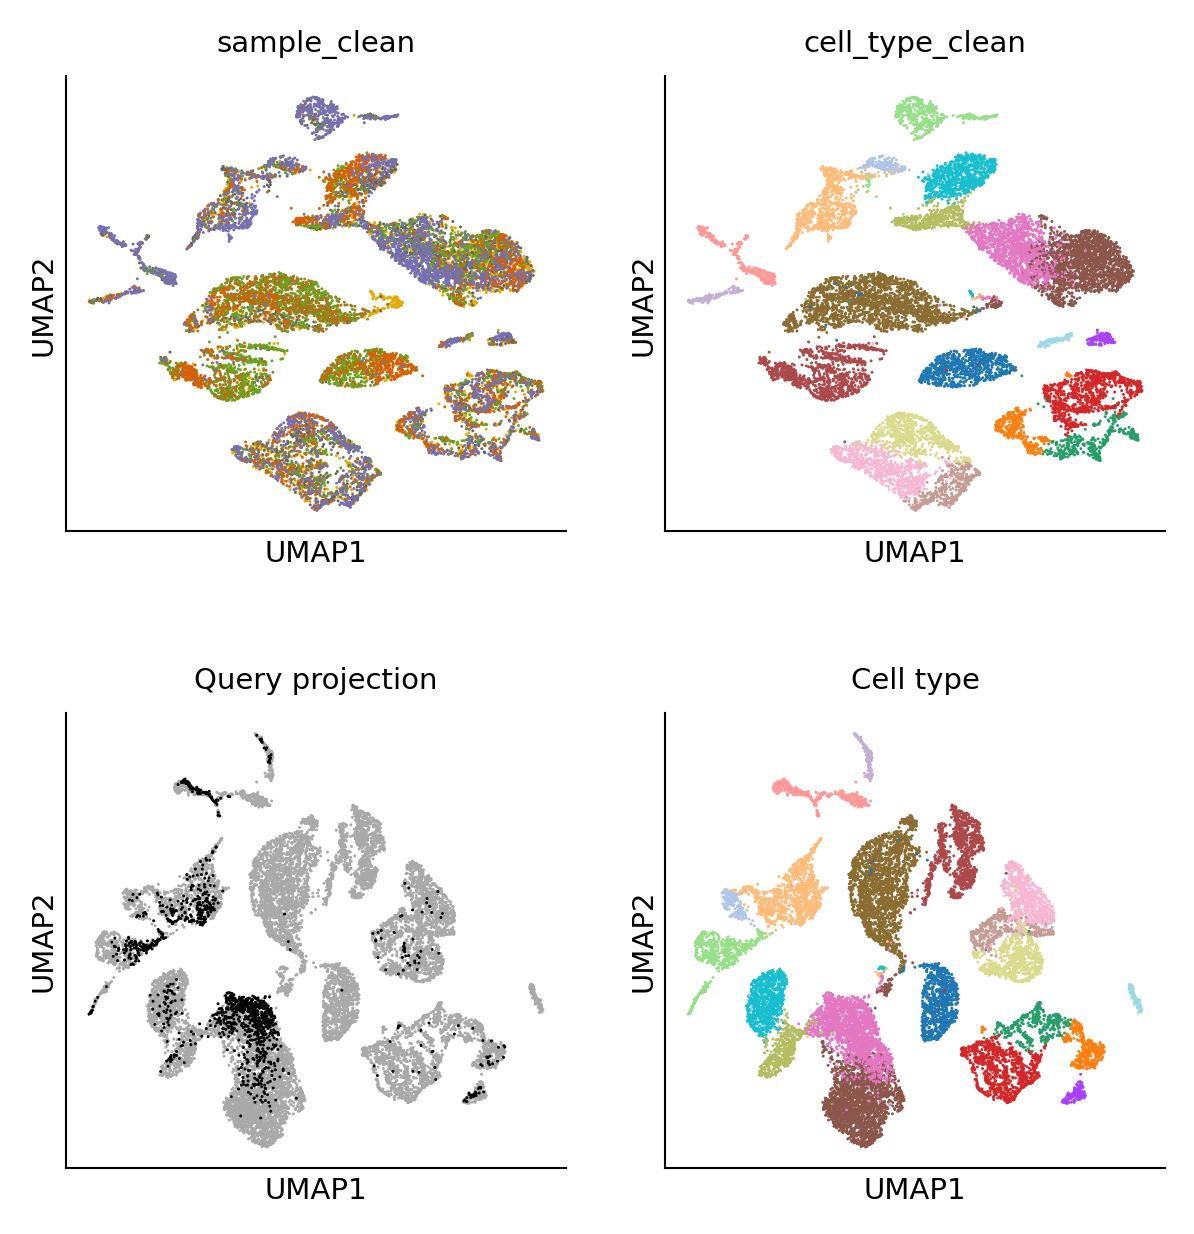

In [21]:
import seaborn as sns

matplotlib.rcParams.update({'font.size': fontsize})
matplotlib.rcParams.update({'legend.markerscale': 0.25})

sample_palette = sns.color_palette("Dark2")

size = 2

fig, axes = plt.subplots(2, 2, dpi=300)
fig.set_size_inches(120*mm, 120*mm)

palette = {
    "NDARKD326LNK (snmC-seq2)": sample_palette[0],
    "NDARKJ183CYT (snmC-seq)": sample_palette[1],
    "UMB4540 (snmC-seq)": sample_palette[2],
    "UMB5577 (sn-m3C-seq)": sample_palette[4],
    "UMB5577 (snmC2T-seq)": sample_palette[5],
    "UMB5580 (sn-m3C-seq)": sample_palette[6],
    "UMB5580 (snmC2T-seq)": sample_palette[7],
}


sc.pl.embedding(
    mdata_ref,
    color='sample_clean',
    ax=axes[0][0],
    show=False,
    size=size,
    palette=palette,
    basis='methylANVI_arches_UMAP'
)
sc.pl.embedding(
    mdata_ref,
    color='cell_type_clean',
    ax=axes[0][1],
    show=False,
    legend_loc=None,
    size=size,
    basis='methylANVI_arches_UMAP'
)
axes[1][0].set_title("Reference sample", fontsize=fontsize)
axes[1][1].set_title("Cell type", fontsize=fontsize)

sc.pl.embedding(
    mdata,
    color='cell_type_clean',
    ax=axes[1][1],
    show=False,
    size=size,
    basis='methylANVI_arches_UMAP'
)
sc.pl.embedding(
    mdata[mdata.obs["dataset"] != "Query"],
    color="dataset",
    palette=["darkgrey", "black"],
    ax=axes[1][0],
    show=False,
    size=size,
    legend_loc=None,
    basis='methylANVI_arches_UMAP'
)
sc.pl.embedding(
    mdata[mdata.obs["dataset"] == "Query"],
    color="dataset",
    palette=["darkgrey", "black"],
    ax=axes[1][0],
    show=False,
    size=size,
    basis='methylANVI_arches_UMAP'
)
axes[1][0].set_title("Query projection", fontsize=fontsize)
axes[1][1].set_title("Cell type", fontsize=fontsize)

platform_label_params = axes[0][0].get_legend_handles_labels() 
legend = axes[0][0].get_legend()
legend.set_visible(False)

cell_type_label_params = axes[1][1].get_legend_handles_labels() 
legend = axes[1][1].get_legend()
legend.set_visible(False)

ref_query_label_params = axes[1][0].get_legend_handles_labels() 
legend = axes[1][0].get_legend()
legend.set_visible(False)

axes = [item for row in axes for item in row]

for ax in axes:
    for axis in ['bottom', 'left']:
        ax.spines[axis].set_linewidth(0.5)
    for axis in ['top', 'right']:
        ax.spines[axis].set_visible(False)
    ax.set_xlabel("UMAP1", fontsize=fontsize, labelpad=2)
    ax.set_ylabel("UMAP2", fontsize=fontsize, labelpad=2)
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_yticklabels([])
        
plt.subplots_adjust(hspace=0.4)

fig.savefig("reference_mapping_qualitative.pdf", dpi=300, transparent=True)

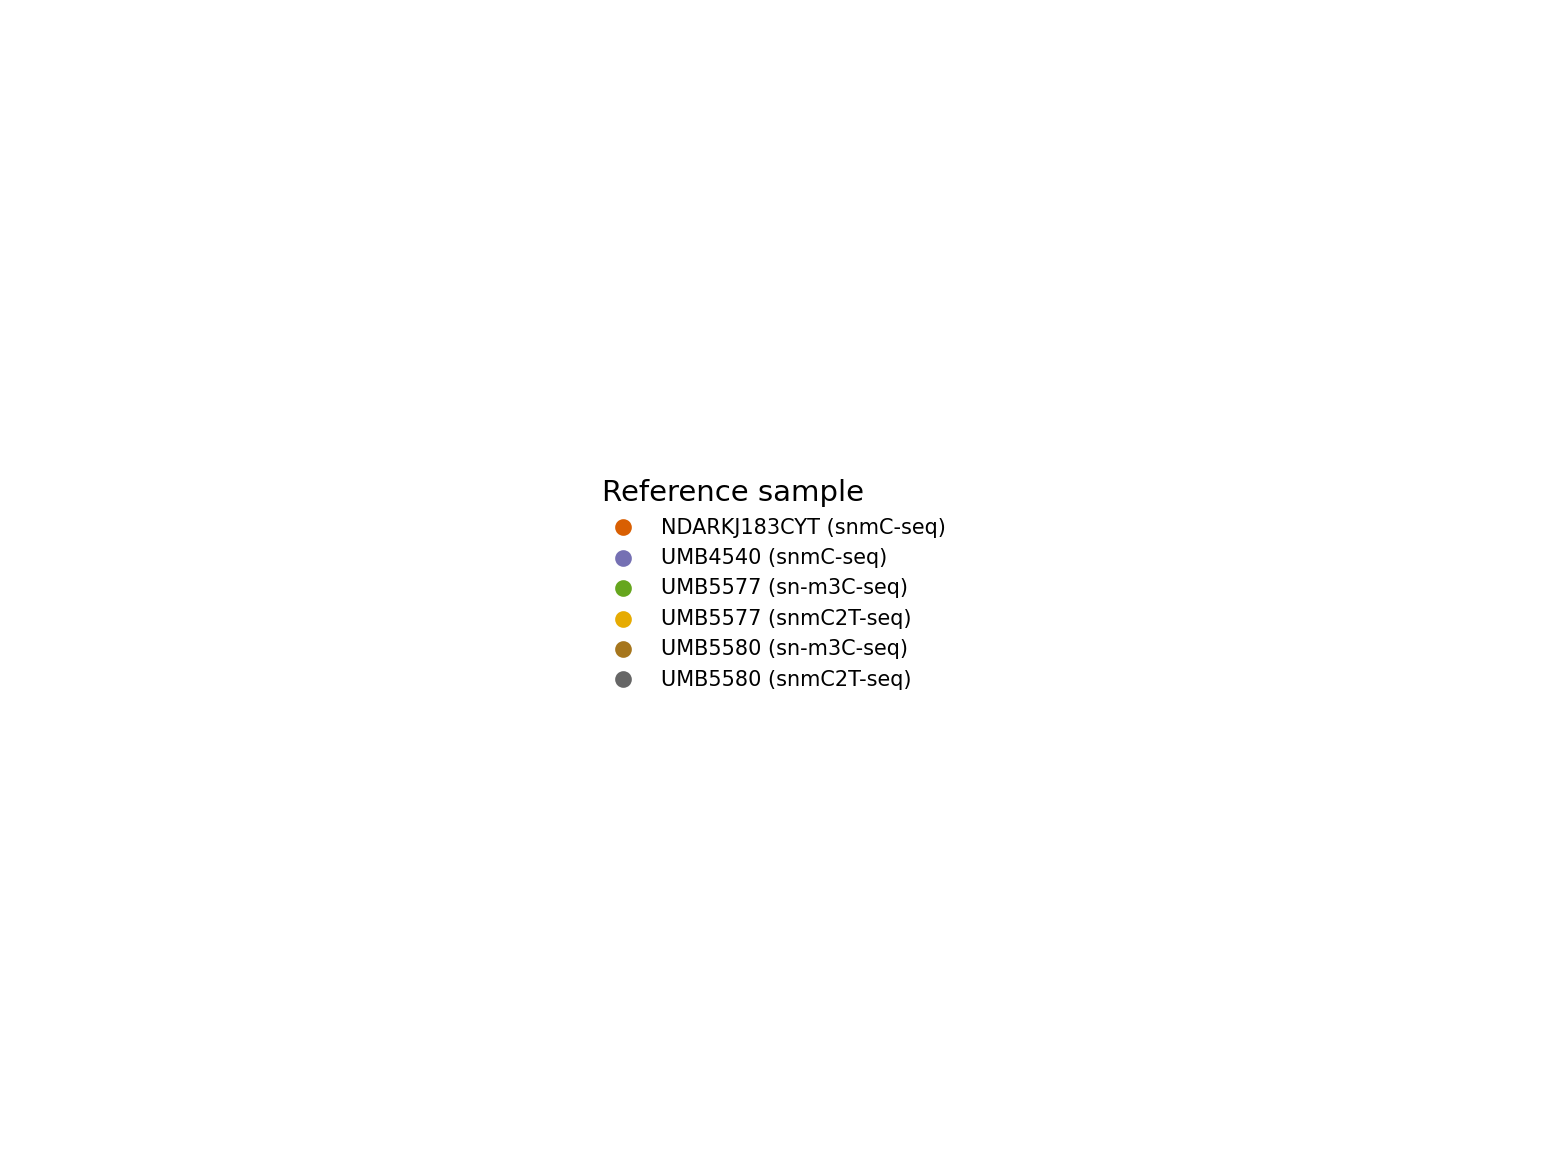

In [22]:
figl, axl = plt.subplots(dpi=300)
axl.axis(False)
axl.legend(
    *platform_label_params,
    loc="center",
    frameon=False,
    markerscale=0.5,
    fontsize=fontsize-2,
    title="Reference sample"
)
leg = axl.get_legend()
leg._legend_box.align = "left"
figl.savefig("platform_legend.pdf", dpi=300)

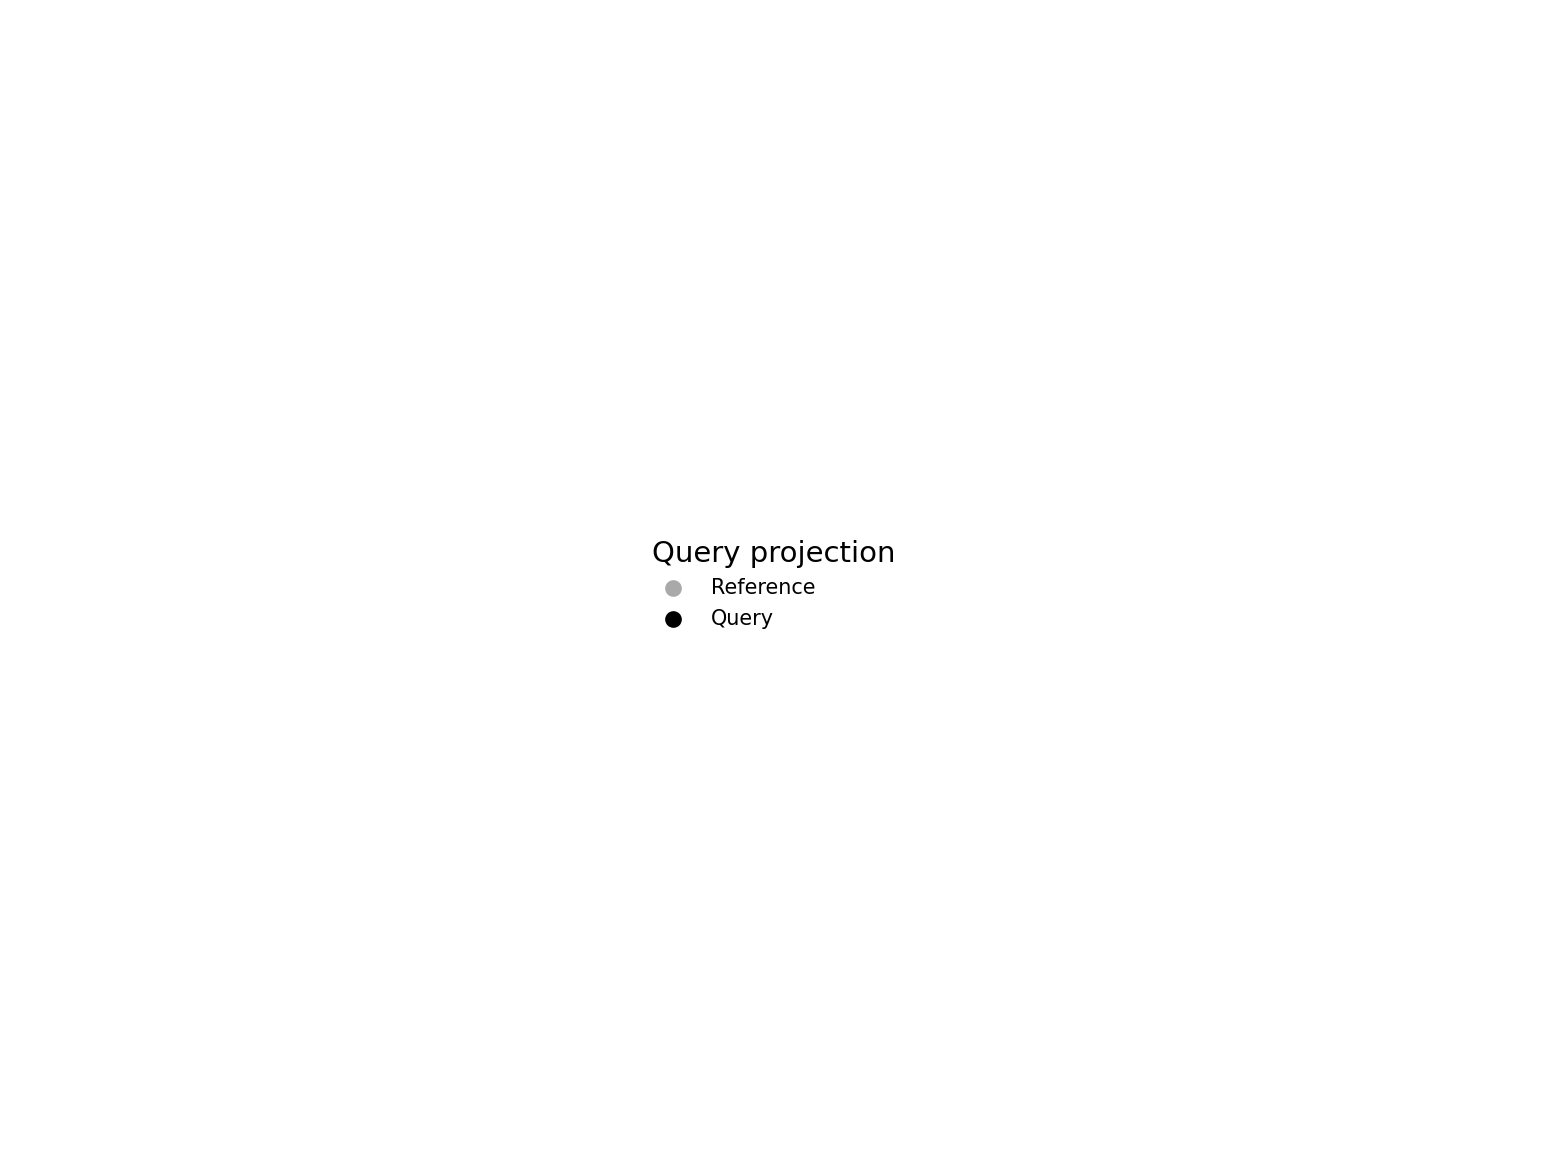

In [23]:
figl, axl = plt.subplots(dpi=300)
axl.axis(False)
axl.legend(
    *ref_query_label_params,
    loc="center",
    frameon=False, 
    markerscale=0.5,
    fontsize=fontsize-2,
    title="Query projection"
)
leg = axl.get_legend()
leg._legend_box.align = "left"
figl.savefig("ref_query_legend.pdf", dpi=300)

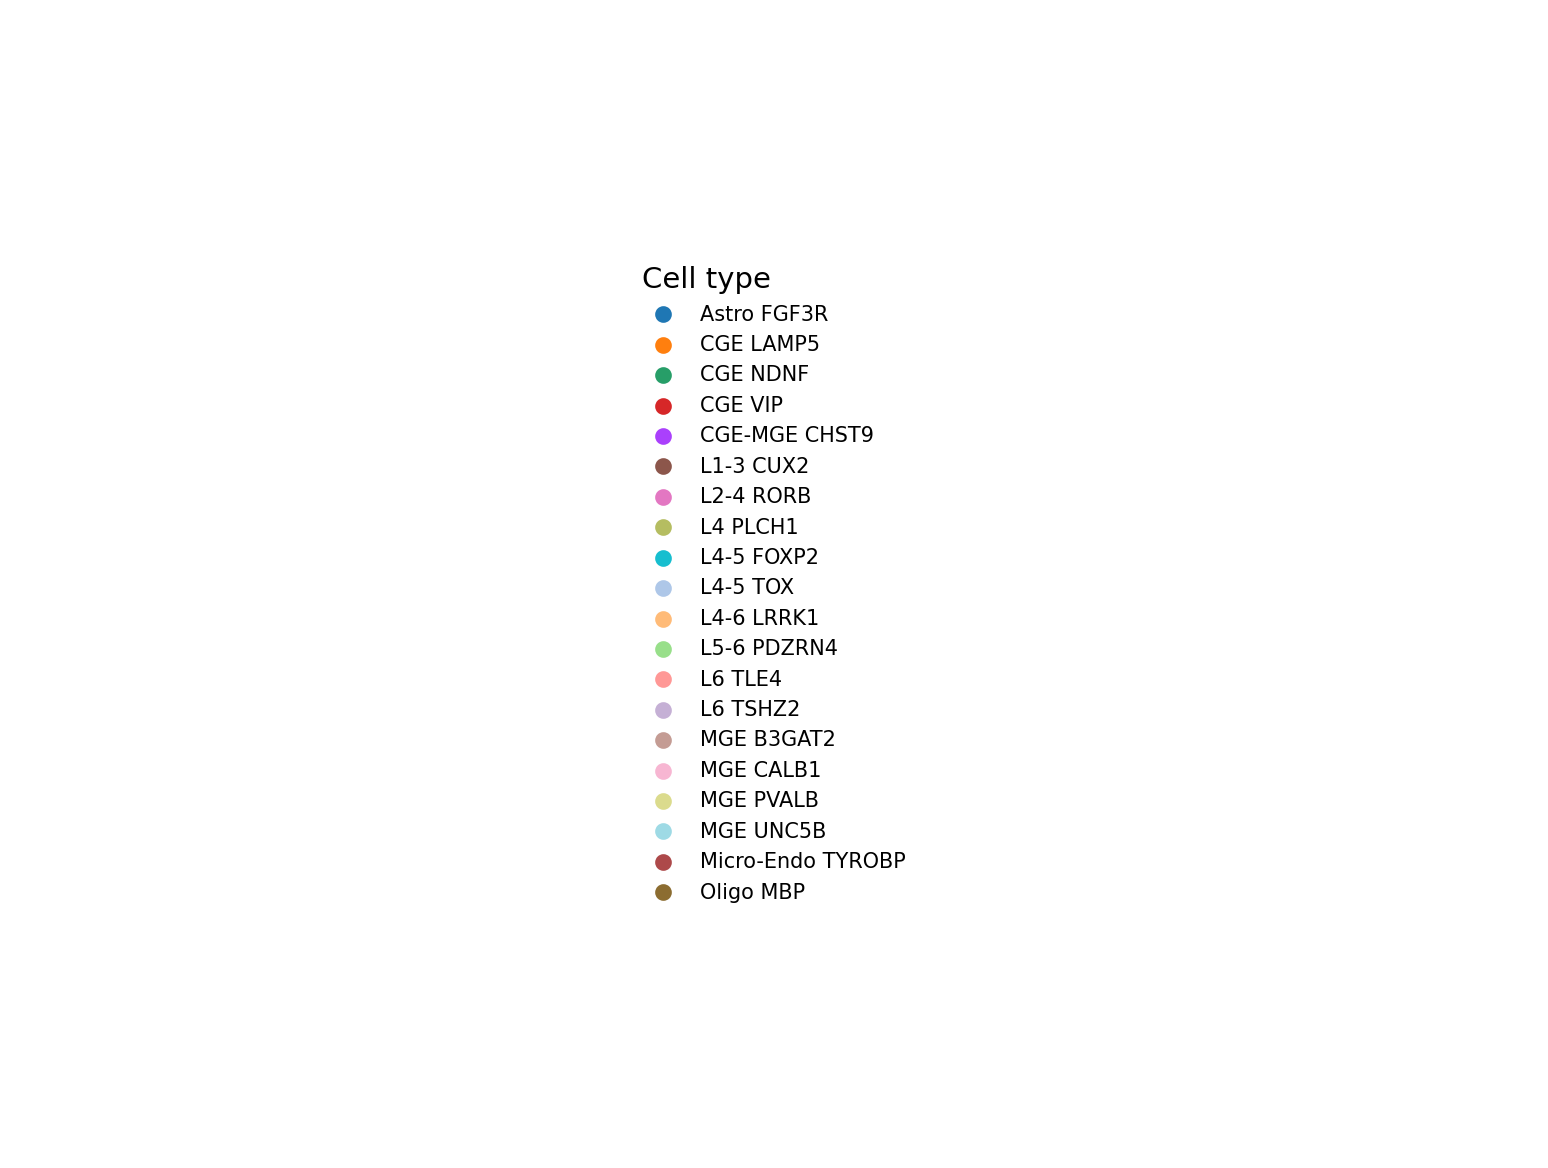

In [24]:
figl, axl = plt.subplots(dpi=300)
axl.axis(False)
axl.legend(
    *cell_type_label_params,
    loc="center",
    frameon=False,
    markerscale=0.5,
    fontsize=fontsize-2,
    title="Cell type"
)
leg = axl.get_legend()
leg._legend_box.align = "left"
figl.savefig("cell_type_legend.pdf", dpi=300)